In [1]:
# from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py

import os
os.environ['CUDA_DEVICE_ID'] = 'PCI_BUS_ORDER'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import argparse
import math
import random

import numpy as np
from tqdm import tqdm
import IPython.display as ipd
from PIL import Image

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch

cuda = True if torch.cuda.is_available() else False

In [2]:

MNIST    = 'mnist'        # https://en.wikipedia.org/wiki/MNIST_database
F_MNIST  = 'fashion_mnist' # https://github.com/zalandoresearch/fashion-mnist
CIPHAR10 = 'ciphar10'     # https://www.cs.toronto.edu/~kriz/cifar.html

DATA_NAME = CIPHAR10


DATA_DIR = f'data/{DATA_NAME}'
GEN_DIR = f'gen_images_{DATA_NAME}'
os.makedirs(GEN_DIR, exist_ok=True)

print(f'torch.version:{torch.__version__}')
print(f'cuda:{cuda}')


!python --version
!pwd
!ls -l

torch.version:1.9.1
cuda:True
Python 3.7.12
/kaggle/working
total 32
---------- 1 root root 25763 Apr 15 08:57 __notebook__.ipynb
drwxr-xr-x 2 root root  4096 Apr 15 08:57 gen_images_ciphar10


In [3]:
n_channel = {MNIST:1, F_MNIST:1, CIPHAR10:3}[DATA_NAME]
img_size =  {MNIST:28, F_MNIST:28, CIPHAR10:32}[DATA_NAME]
VISION_DATASET =  {MNIST:datasets.MNIST, F_MNIST:datasets.FashionMNIST, CIPHAR10:datasets.CIFAR10}[DATA_NAME]

class Option:
    def __init__(self):
        self.n_epochs = 50         # number of epochs of training
        self.batch_size = 64       # size of the batches
        self.lr = 0.0002           # adam: learning rate
        self.b1 = 0.5              # adam: decay of first order momentum of gradient
        self.b2 = 0.999            # adam: decay of first order momentum of gradient
        self.n_cpu = 2             # number of cpu threads to use during batch generation
        self.latent_dim = 100      # dimensionality of the latent space
        self.n_classes = 10        # number of classes for dataset
        self.img_size = img_size   # size of each image dimension
        self.channels = n_channel  # number of image channels
        self.sample_interval = 400 # interval between image sampling")
        
opt = Option()
vars(opt)

{'n_epochs': 50,
 'batch_size': 64,
 'lr': 0.0002,
 'b1': 0.5,
 'b2': 0.999,
 'n_cpu': 2,
 'latent_dim': 100,
 'n_classes': 10,
 'img_size': 32,
 'channels': 3,
 'sample_interval': 400}

In [4]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

DCGAN을 활용하여 Generator , Discriminator 수정 /
https://subinium.github.io/VanillaGAN/

https://psh7286.tistory.com/entry/DCGAN%EC%9C%BC%EB%A1%9C-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EB%8A%94-CIFAR-10

In [5]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)

#         def block(in_feat, out_feat, normalize=True):
#             layers = [nn.Linear(in_feat, out_feat)]
#             if normalize:
#                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
#             *block(128, 256),
#             *block(256, 512),
#             *block(512, 1024),
#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()
#         )

#     def forward(self, noise, labels):
#         # Concatenate label embedding and image to produce input
#         gen_input = torch.cat((self.label_emb(labels), noise), -1)
#         img = self.model(gen_input)
#         img = img.view(img.size(0), *img_shape)
#         return img
    
# # Create generator 
# generator = Generator()
# generator

없는 옵션 변수는 하드코딩으로 집어 넣었습니다.

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)
        
        self.model = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( opt.latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. (ngf) x 32 x 32
            nn.ConvTranspose2d( 64, 3 , 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. (nc) x 64 x 64
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

generator = Generator()
generator

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), b

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
            nn.Conv2d(opt.channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1 , 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity
# Create discriminator
discriminator = Discriminator()
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [8]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    

In [9]:
# Configure data loader

os.makedirs(DATA_DIR, exist_ok=True)

ds = VISION_DATASET(DATA_DIR, train=True,download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), 
             transforms.ToTensor(), 
             transforms.Normalize([0.5], [0.5])
            ]
        ),
    )

dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=opt.batch_size,
    shuffle=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/ciphar10/cifar-10-python.tar.gz to data/ciphar10


[0] airplane


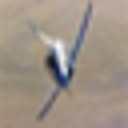

[6] frog


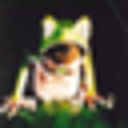

[3] cat


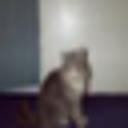

[2] bird


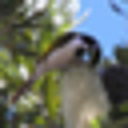

[0] airplane


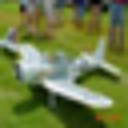

[1] automobile


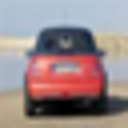

[1] automobile


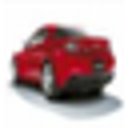

[8] ship


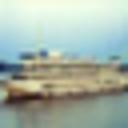

[1] automobile


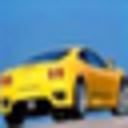

[9] truck


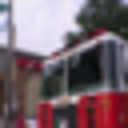

In [10]:
for _ in range(10):
    img, label =  random.choice(ds)
    img = ((img + 1)/2*255).type(torch.uint8).permute((1,2,0)).squeeze()
    print(f'[{label}] {ds.classes[label]}')
    display(Image.fromarray(img.numpy()).resize((128, 128)))

In [11]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [12]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_width, epoch, n_label = 10):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.Tensor(np.random.normal(0, 1, (n_width* n_label, opt.latent_dim))).type(FloatTensor)
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([label for label in range(n_label) for _ in range(n_width)])
    labels = torch.Tensor(labels).type(LongTensor)
    gen_imgs = generator(z, labels)
    img_path = f"{GEN_DIR}/{epoch:06d}.png"
    save_image(gen_imgs.data, img_path, nrow=n_width, normalize=True)
    return img_path


In [13]:
# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    print(f'{epoch+1}/{opt.n_epochs}')
    if epoch:
        print(f'D loss: {d_loss.item():.04f},  G loss: {g_loss.item()}')
        display(Image.open(img_path))
        
        
    for i, (imgs, labels) in enumerate(tqdm(dataloader)):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = FloatTensor(batch_size, 1).fill_(1.0)
        fake  = FloatTensor(batch_size, 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(FloatTensor)
        labels = labels.type(LongTensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim)))
        gen_labels = LongTensor(np.random.randint(0, opt.n_classes, batch_size))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    img_path = sample_image(n_width=30, epoch=epoch, n_label=opt.n_classes)
    ipd.clear_output(wait=True)

1/50


  0%|          | 0/782 [00:00<?, ?it/s]


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [100, 512, 4, 4], but got 2-dimensional input of size [64, 110] instead

오류 디버깅 과정

'Generator' object has no attribute 'label_emb'
DCGAN 코드를 참조하여 제너레이터를 변경하였으나, label_emb 속성이 없는 오류가 발생하여 
기존 CGAN의 label_emb 코드를 붙여넣었습니다. 

forward() takes 2 positional arguments but 3 were given

DCGAN의 포워드 함수를 가져다 쓰다보니 입력으로 받아와야하는 값의 수가 달라 오류가 발생하는 것으로 보여 다시 CGAN의 포워드 함수를 사용 

Expected 4-dimensional input for 4-dimensional weight [100, 512, 4, 4], but got 2-dimensional input of size [64, 110] instead

입력값의 차원이 다른 오류가뜸 

.unsqueeze(0) 이라는 차원을 추가하는 함수를 인풋에 적용함 
Expected 4-dimensional input for 4-dimensional weight [100, 512, 4, 4], but got 3-dimensional input of size [1, 64, 110] instead

4차원대 2차원에서  4차원대 3차원이됨



인풋차원이 다른문제를 해결을 어떻게 해야할지 감이 안잡혀 이런저런 코드들을 수정해보는중